# Popular CNN Architectures, Tensorboard, Transfer Learning

# 1. Transfer Learning

In [1]:
import os
import shutil
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, models, transforms
from torchvision.utils import save_image
from torch.utils.tensorboard import SummaryWriter

/home/faris/miniconda3/envs/cudalab/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In this tutorial, you will learn how to train your network using transfer learning. You can read more about the transfer learning at `cs231n notes http://cs231n.github.io/transfer-learning/

Quoting this notes,
```
In practice, very few people train an entire Convolutional Network
from scratch (with random initialization), because it is relatively
rare to have a dataset of sufficient size. Instead, it is common to
pretrain a ConvNet on a very large dataset (e.g. ImageNet, which
contains 1.2 million images with 1000 categories), and then use the
ConvNet either as an initialization or a fixed feature extractor for
the task of interest.
```

These major transfer learning scenarios look as follows:

 - **Finetuning the CNN**: Instead of random initializaion, we initialize the network with a pretrained network, like the one that is trained on the Imagenet dataset. Rest of the training looks as usual.
 
 - **CNN as fixed feature extractor**: Here, we will freeze the weights for all of the network except that of the final fully connected classifier. This last fully connected layer is replaced with a new one with random weights and only this layer is trained.
 
 - **Combined Approach**: Training first the classifier only, and then doing some joined fine-tuning of both CNN feature extractor and classifier

The problem we're going to solve today is to train a model to classify ants and bees. We have about 120 training images each for ants and bees. There are 75 validation images for each class. Usually, this is a very small dataset to generalize upon, if trained from scratch. Since we are using transfer learning, we should be able to generalize reasonably well.

This dataset is a very small subset of imagenet.

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Data Loading

In [3]:
# Download data
# !wget https://download.pytorch.org/tutorial/hymenoptera_data.zip

In [4]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [5]:
data_dir = 'data/hymenoptera_data'

In [6]:
train_dataset = datasets.ImageFolder(os.path.join(data_dir, "train"), data_transforms["train"])
valid_dataset = datasets.ImageFolder(os.path.join(data_dir, "val"), data_transforms["val"])

In [7]:
N_train = len(train_dataset)
N_valid = len(valid_dataset)
print(f"Training set size: {N_train} images")
print(f"Valdiation set size: {N_valid} images")

Training set size: 244 images
Valdiation set size: 153 images


In [8]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=32, shuffle=True, num_workers=4)

In [9]:
class_names = train_dataset.classes
print(class_names)

['ants', 'bees']


## Data Visualization

In [10]:
def show_grid(data, titles=None):
    """Imshow for Tensor."""
    data = data.numpy().transpose((0, 2, 3, 1))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    data = std * data + mean
    data = np.clip(data, 0, 1)
    
    plt.figure(figsize=(8*2, 4*2))
    for i in range(32):
        plt.subplot(4,8,i+1)
        plt.imshow(data[i])
        plt.axis("off")
        if titles is not None:
            plt.title(titles[i])
    plt.tight_layout()
    plt.show()

In [11]:
# Get a batch of training data and displaying it
inputs, classes = next(iter(train_loader))
titles = [class_names[x] for x in classes]

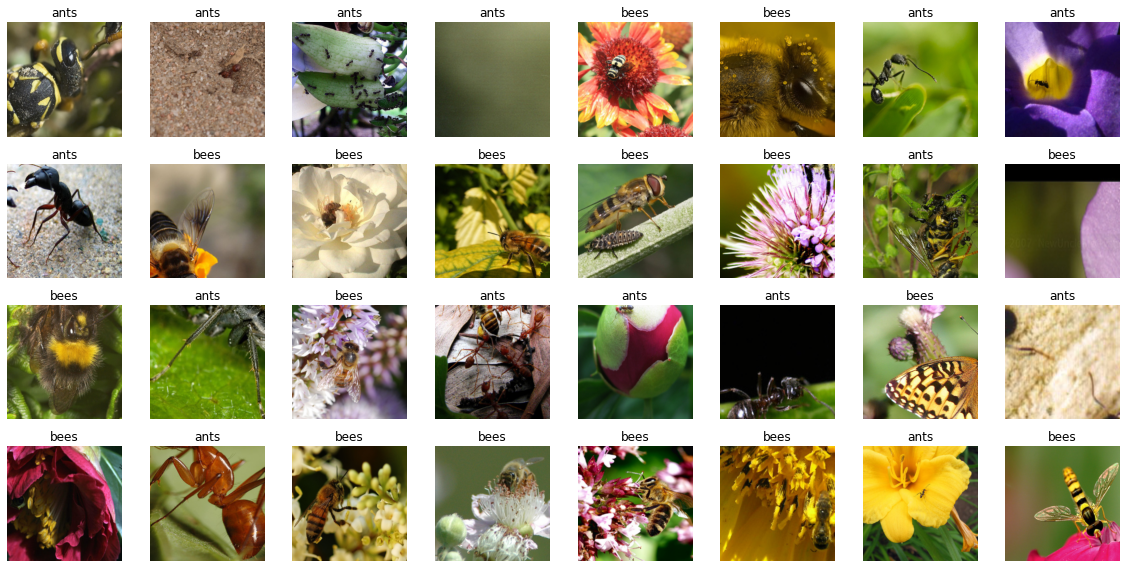

In [12]:
show_grid(inputs, titles=titles)

## Main code

In [13]:
def train_epoch(model, train_loader, optimizer, criterion, device):
    """ Training a model for one epoch """
    
    loss_list = []
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
         
        # Forward pass to get output/logits
        outputs = model(images)
         
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())
         
        # Getting gradients w.r.t. parameters
        loss.backward()
         
        # Updating parameters
        optimizer.step()
        
    mean_loss = np.mean(loss_list)
    return mean_loss, loss_list

In [14]:
@torch.no_grad()
def eval_model(model, eval_loader, criterion, device):
    """ Evaluating the model for either validation or test """
    correct = 0
    total = 0
    loss_list = []
    
    for images, labels in eval_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass only to get logits/output
        outputs = model(images)
                 
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())
            
        # Get predictions from the maximum value
        preds = torch.argmax(outputs, dim=1)
        correct += len( torch.where(preds==labels)[0] )
        total += len(labels)
                 
    # Total correct predictions and loss
    accuracy = correct / total * 100
    loss = np.mean(loss_list)
    
    return accuracy, loss

In [15]:
def train_model(model, optimizer, scheduler, criterion, train_loader, valid_loader, num_epochs, tboard=None, start_epoch=0):
    """ Training a model for a given number of epochs"""
    
    train_loss = []
    val_loss =  []
    loss_iters = []
    valid_acc = []
    
    for epoch in tqdm(range(num_epochs)):
           
        # validation epoch
        model.eval()  # important for dropout and batch norms
        accuracy, loss = eval_model(
                    model=model, eval_loader=valid_loader,
                    criterion=criterion, device=device
            )
        valid_acc.append(accuracy)
        val_loss.append(loss)
        writer.add_scalar(f'Accuracy/Valid', accuracy, global_step=epoch+start_epoch)
        writer.add_scalar(f'Loss/Valid', loss, global_step=epoch+start_epoch)
        
        # training epoch
        model.train()  # important for dropout and batch norms
        mean_loss, cur_loss_iters = train_epoch(
                model=model, train_loader=train_loader, optimizer=optimizer,
                criterion=criterion, device=device
            )
        scheduler.step()
        train_loss.append(mean_loss)
        writer.add_scalar(f'Loss/Train', mean_loss, global_step=epoch+start_epoch)

        loss_iters = loss_iters + cur_loss_iters
        
        if(epoch % 5 == 0 or epoch==num_epochs-1):
            print(f"Epoch {epoch+1}/{num_epochs}")
            print(f"    Train loss: {round(mean_loss, 5)}")
            print(f"    Valid loss: {round(loss, 5)}")
            print(f"    Accuracy: {accuracy}%")
            print("\n")
    
    print(f"Training completed")
    return train_loss, val_loss, loss_iters, valid_acc

In [16]:
def save_model(model, optimizer, epoch, stats):
    """ Saving model checkpoint """
    
    if(not os.path.exists("models")):
        os.makedirs("models")
    savepath = f"models/checkpoint_epoch_{epoch}.pth"

    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'stats': stats
    }, savepath)
    return

In [17]:
def load_model(model, optimizer, savepath):
    """ Loading pretrained checkpoint """
    
    checkpoint = torch.load(savepath)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint["epoch"]
    stats = checkpoint["stats"]
    
    return model, optimizer, epoch, stats

In [18]:
def set_random_seed(random_seed=None):
    """
    Using random seed for numpy and torch
    """
    if(random_seed is None):
        random_seed = 13
    os.environ['PYTHONHASHSEED'] = str(random_seed)
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    return

## Model

We get a pretrained ResNet-18 model. We keep the convolutional part, but drop the fully-connected classification head and make one of our own.

ResNet links:
   - https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html
   - https://pytorch.org/vision/stable/models.html
   - https://pytorch.org/hub/pytorch_vision_resnet/
   - https://de.mathworks.com/help/deeplearning/ref/resnet18.html
   - https://medium.com/@kirudang/deep-learning-computer-vision-using-transfer-learning-resnet-18-in-pytorch-skin-cancer-8d5b158893c5
   - https://medium.com/analytics-vidhya/resnet-understand-and-implement-from-scratch-d0eb9725e0db
   - https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py

In [19]:
set_random_seed()

In [20]:
model = models.resnet18(weights = models.ResNet18_Weights.IMAGENET1K_V1)
#model = models.resnet18(pretrained=True)

In [21]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [22]:
# Change fc layer from original paper with our architecture
model.fc = nn.Sequential(
        nn.Linear(512,256),
        nn.ReLU(),
        nn.Linear(256,2)
)

In [23]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Training our model

In [24]:
# downloading pretrained model
# https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py
# Use pretrained weights (weights that has been learned during training of RESNET18 on image net)
model = models.resnet18(weights = models.ResNet18_Weights.IMAGENET1K_V1) # validation set accuracy: 92.8 %
# Use random weights (not using weights that are learned during training of RESNET18 on image net)
# model = models.resnet18(weights = None) # validation set accuracy: 74.5 %
# model = models.resnet18(pretrained=True) => deprecated way of using pretrained weights

# replacing classification head
num_nuerons = model.fc.in_features
model.fc = nn.Linear(num_nuerons, 2)

model = model.to(device)

In [25]:
# classification loss function
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [26]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Accessing layers in model architecture

In [27]:
model.conv1

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [28]:
model.layer1[0].conv1

Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

In [29]:
model.avgpool

AdaptiveAvgPool2d(output_size=(1, 1))

In [30]:
model.fc

Linear(in_features=512, out_features=2, bias=True)

## Approaches

These major transfer learning scenarios look as follows:

 - **Finetuning the CNN**: Instead of random initializaion, we initialize the network with a pretrained network, like the one that is trained on the Imagenet dataset. Rest of the training looks as usual.
 
 - **CNN as fixed feature extractor**: Here, we will freeze the weights for all of the network except that of the final fully connected classifier. This last fully connected layer is replaced with a new one with random weights and only this layer is trained.
 
 - **Combined Approach**: Training first the classifier only, and then doing some joined fine-tuning of both CNN feature extractor and classifier

## 1. Finetuning the CNN

In [31]:
TBOARD_LOGS = os.path.join(os.getcwd(), "tboard_logs", "CNN_tuned")
if not os.path.exists(TBOARD_LOGS):
    os.makedirs(TBOARD_LOGS)

shutil.rmtree(TBOARD_LOGS)
writer = SummaryWriter(TBOARD_LOGS)

In [32]:
train_loss, val_loss, loss_iters, valid_acc = train_model(
        model=model, optimizer=optimizer, scheduler=scheduler, criterion=criterion,
        train_loader=train_loader, valid_loader=valid_loader, num_epochs=15, tboard=writer
    )

  7%|▋         | 1/15 [00:06<01:36,  6.88s/it]

Epoch 1/15
    Train loss: 0.37895
    Valid loss: 0.75571
    Accuracy: 52.94117647058824%




 40%|████      | 6/15 [00:24<00:32,  3.60s/it]

Epoch 6/15
    Train loss: 0.22299
    Valid loss: 0.7572
    Accuracy: 83.00653594771242%




 73%|███████▎  | 11/15 [00:40<00:13,  3.37s/it]

Epoch 11/15
    Train loss: 0.10245
    Valid loss: 0.27717
    Accuracy: 90.84967320261438%




100%|██████████| 15/15 [00:53<00:00,  3.59s/it]

Epoch 15/15
    Train loss: 0.04178
    Valid loss: 0.30444
    Accuracy: 92.15686274509804%


Training completed


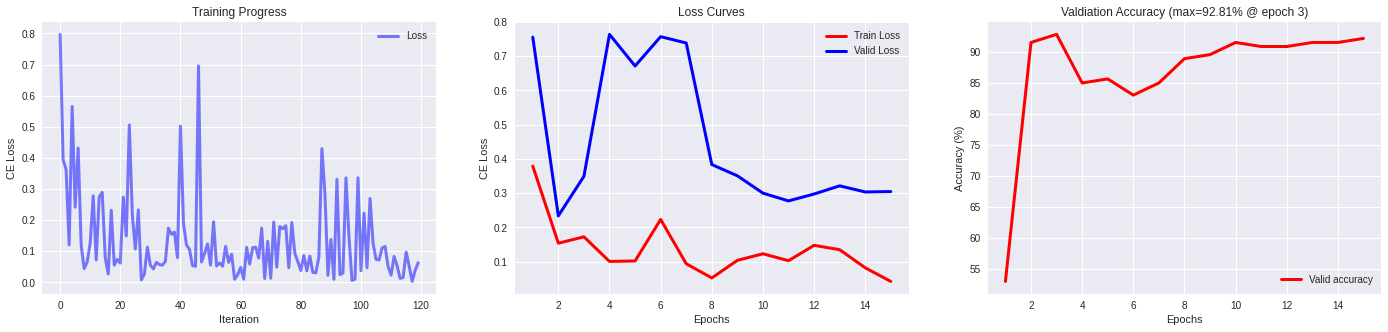

In [33]:
plt.style.use('seaborn')
fig, ax = plt.subplots(1,3)
fig.set_size_inches(24,5)

ax[0].plot(loss_iters, c="blue", label="Loss", linewidth=3, alpha=0.5)
ax[0].legend(loc="best")
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("CE Loss")
ax[0].set_title("Training Progress")

epochs = np.arange(len(train_loss)) + 1
ax[1].plot(epochs, train_loss, c="red", label="Train Loss", linewidth=3)
ax[1].plot(epochs, val_loss, c="blue", label="Valid Loss", linewidth=3)
ax[1].legend(loc="best")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("CE Loss")
ax[1].set_title("Loss Curves")

epochs = np.arange(len(val_loss)) + 1
ax[2].plot(epochs, valid_acc, c="red", label="Valid accuracy", linewidth=3)
ax[2].legend(loc="best")
ax[2].set_xlabel("Epochs")
ax[2].set_ylabel("Accuracy (%)")
ax[2].set_title(f"Valdiation Accuracy (max={round(np.max(valid_acc),2)}% @ epoch {np.argmax(valid_acc)+1})")

plt.show()

## 2. CNN as fixed feature extractor

Here, we need to freeze all the network except the final layer. We need to set requires_grad == False to freeze the parameters so that the gradients are not computed in backward().

You can read more about this in the documentation here: http://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward

In [34]:
set_random_seed()

In [35]:
fixedModel = models.resnet18(weights = models.ResNet18_Weights.IMAGENET1K_V1)

In [36]:
# Freezing model parameters
for param in fixedModel.parameters():
    param.requires_grad = False

In [37]:
# Parameters of newly constructed modules have requires_grad=True by default
num_logits = fixedModel.fc.in_features
fixedModel.fc = nn.Linear(num_logits, 2)
fixedModel = fixedModel.to(device)

In [38]:
# classification loss function
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = torch.optim.Adam(fixedModel.parameters(), lr=3e-4)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [39]:
TBOARD_LOGS = os.path.join(os.getcwd(), "tboard_logs", "CNN_fixed")
if not os.path.exists(TBOARD_LOGS):
    os.makedirs(TBOARD_LOGS)

shutil.rmtree(TBOARD_LOGS)
writer = SummaryWriter(TBOARD_LOGS)

In [40]:
train_loss, val_loss, loss_iters, valid_acc = train_model(
        model=fixedModel, optimizer=optimizer, scheduler=scheduler, criterion=criterion,
        train_loader=train_loader, valid_loader=valid_loader, num_epochs=15, tboard=writer, start_epoch=0
    )

  7%|▋         | 1/15 [00:02<00:37,  2.67s/it]

Epoch 1/15
    Train loss: 0.73083
    Valid loss: 0.68681
    Accuracy: 60.78431372549019%




 40%|████      | 6/15 [00:16<00:25,  2.83s/it]

Epoch 6/15
    Train loss: 0.46795
    Valid loss: 0.48601
    Accuracy: 83.00653594771242%




 73%|███████▎  | 11/15 [00:30<00:10,  2.71s/it]

Epoch 11/15
    Train loss: 0.41569
    Valid loss: 0.41609
    Accuracy: 88.88888888888889%




100%|██████████| 15/15 [00:41<00:00,  2.76s/it]

Epoch 15/15
    Train loss: 0.39417
    Valid loss: 0.40636
    Accuracy: 89.54248366013073%


Training completed


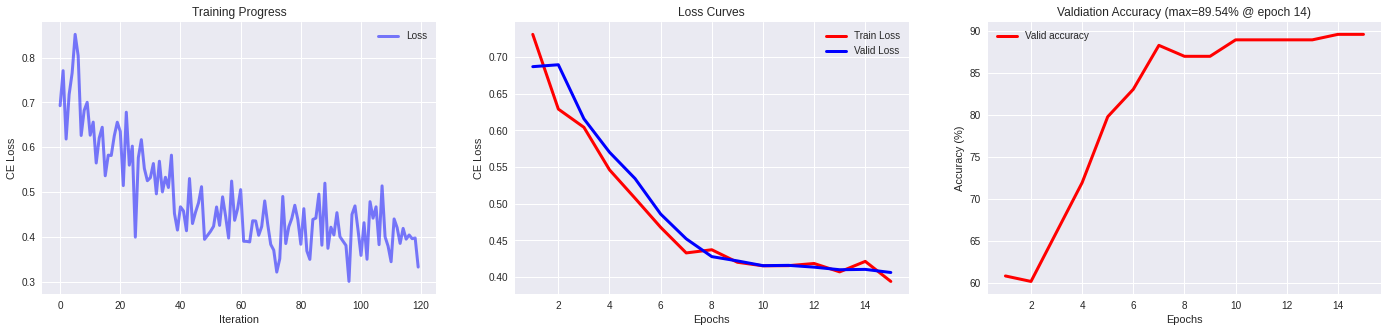

In [41]:
plt.style.use('seaborn')
fig, ax = plt.subplots(1,3)
fig.set_size_inches(24,5)

ax[0].plot(loss_iters, c="blue", label="Loss", linewidth=3, alpha=0.5)
ax[0].legend(loc="best")
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("CE Loss")
ax[0].set_title("Training Progress")

epochs = np.arange(len(train_loss)) + 1
ax[1].plot(epochs, train_loss, c="red", label="Train Loss", linewidth=3)
ax[1].plot(epochs, val_loss, c="blue", label="Valid Loss", linewidth=3)
ax[1].legend(loc="best")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("CE Loss")
ax[1].set_title("Loss Curves")

epochs = np.arange(len(val_loss)) + 1
ax[2].plot(epochs, valid_acc, c="red", label="Valid accuracy", linewidth=3)
ax[2].legend(loc="best")
ax[2].set_xlabel("Epochs")
ax[2].set_ylabel("Accuracy (%)")
ax[2].set_title(f"Valdiation Accuracy (max={round(np.max(valid_acc),2)}% @ epoch {np.argmax(valid_acc)+1})")

plt.show()

## 3. Combined Approach

# References

 - https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
 - https://www.deeplearningbook.org/
 - http://cs231n.stanford.edu/
 - https://towardsdatascience.com/classifying-images-of-alcoholic-beverages-with-fast-ai-34c4560b5543